In [2]:
import os
import re
import csv
import json
import math
import openai
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from datetime import datetime
from collections import defaultdict, Counter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import altair as alt

## Preparing the data

In [33]:
bigfive_human_data = pd.read_csv('data/bigfive_data.csv', delimiter='\t')
bigfive_human_data['hue'] = 'Human'
bigfive_human_data.head()

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O2,O3,O4,O5,O6,O7,O8,O9,O10,hue
0,3,53,1,1,1,1,US,4,2,5,...,1,3,1,5,1,4,2,5,5,Human
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,2,3,3,1,3,2,Human
2,1,14,2,2,1,1,PK,5,1,1,...,5,5,1,5,1,5,5,5,5,Human
3,3,19,2,2,1,1,RO,2,5,2,...,3,5,2,4,2,5,2,5,5,Human
4,11,25,2,2,1,2,US,3,1,3,...,1,1,1,3,1,3,1,5,3,Human


In [34]:
### independent 30 instances
records_gpt4 = json.load(open('records/bigfive_gpt4_2023_06_26-01_37_11_PM.json', 'r'))
records_turbo = json.load(open('records/bigfive_turbo_2023_06_26-02_06_26_AM.json', 'r'))


In [35]:
bigfive_model_data = {}
bigfive_model_data['gpt4'] = pd.DataFrame(records_gpt4['choices'])
bigfive_model_data['turbo'] = pd.DataFrame(records_turbo['choices'])
bigfive_model_data['gpt4']['hue'] = 'ChatGPT-4'
bigfive_model_data['turbo']['hue'] = 'ChatGPT-3'

In [36]:
questions = {}
with open('data/bigfive.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        questions[row[0]] = row[1]

keyed = {}
indices = defaultdict(int)
dimensions = 'EACNO'
with open('data/bigfive_IPIP.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        d = dimensions[int(row[-1][1])-1]
        v = row[-1][2]
        indices[d] += 1
        k = '%s%i' % (d, indices[d])
        keyed[k] = v

In [37]:
models = ['gpt4', 'turbo']
beg_pos = list(range(7, 100, 10))[:5]
# d_scores_model = defaultdict(dict)

dimensions = 'ENACO'
for i, d in enumerate(dimensions):
    
    ### human scores
    d_score = 0
    for j in range(10):
        k = '%s%i' % (d, j+1)
        v = keyed[k]
        score = bigfive_human_data.iloc[:, beg_pos[i]+j]
        if v == '-': score = 6 - score
        d_score += score
    bigfive_human_data[d] = d_score

    ### model scores
    for model in models:
        d_score = 0
        records = eval('records_%s' % model)
        for j in range(10):
            k = '%s%i' % (d, j+1)
            v = keyed[k]
            score = bigfive_model_data[model].iloc[:, i*10+j]
            # score = np.mean(records['choices'][k])
            if v == '-': score = 6 - score
            d_score += score
        # d_scores_model[model][d] = d_score
        bigfive_model_data[model][d] = d_score

In [38]:
data = pd.concat([
    bigfive_human_data, 
    bigfive_model_data['gpt4'], 
    bigfive_model_data['turbo']
], ignore_index=True)
data[['E', 'hue']]
data['N'] = 60 - data['N']
data[[*dimensions, 'hue']]

,E,N,A,C,O,hue
0,44,11,46,47,43,Human
1,22,31,35,42,26,Human
2,35,46,38,49,45,Human
3,22,43,37,26,41,Human
4,34,30,44,34,34,Human
...,...,...,...,...,...,...
19774,30,30,30,33,28,ChatGPT-3
19775,30,30,32,32,28,ChatGPT-3
19776,31,30,30,33,29,ChatGPT-3
19777,30,30,32,33,28,ChatGPT-3


In [39]:
from scipy.stats import percentileofscore

for d in dimensions:
    median_gpt4 = np.median(data[data['hue'] == 'ChatGPT-4'][d])
    median_turbo = np.median(data[data['hue'] == 'ChatGPT-3'][d])
    print(d, median_gpt4, median_turbo)
    human_data = data[data['hue'] == 'Human'][d]
    print('gpt4', percentileofscore(human_data, median_gpt4))
    print('turbo', percentileofscore(human_data, median_turbo))

E 31.0 30.0
gpt4 53.35209696232061
turbo 49.35087986206197
N 29.0 30.0
gpt4 41.27491252091892
turbo 45.41812465135149
A 36.0 32.0
gpt4 32.38754500735332
turbo 17.237182412901266
C 36.0 33.0
gpt4 62.695877072873884
turbo 47.101780009128255
O 37.5 28.0
gpt4 37.943100562908874
turbo 4.962219179471576


Resulting dataframe to be used

In [40]:
records = []
categories = {'E': 'Extraversion', 'N': 'Neuroticism', 'A':'Agreeableness', 'C':'Conscientiousness', 'O':'Openness'}

# Iterate through each dimension and calculate the median values and percentile scores for GPT-4 and GPT-3 (Turbo)
for d in dimensions:
    median_gpt4 = np.median(data[data['hue'] == 'ChatGPT-4'][d])
    median_gpt3 = np.median(data[data['hue'] == 'ChatGPT-3'][d])
    median_human = np.median(data[data['hue'] == 'Human'][d])
    
    human_data = data[data['hue'] == 'Human'][d]
    
    percentile_gpt4 = percentileofscore(human_data, median_gpt4)/100
    percentile_gpt3 = percentileofscore(human_data, median_gpt3)/100
    percentile_human = percentileofscore(human_data, median_human)/100
    
    # Append a dictionary with the results for GPT-4
    records.append({
        'Model': 'ChatGPT-4',
        'PercentileScore': percentile_gpt4,
        'MedianScore': median_gpt4,
        'Dimension': categories[d]
    })
    
    # Append a dictionary with the results for GPT-3 (Turbo)
    records.append({
        'Model': 'ChatGPT-3',
        'PercentileScore': percentile_gpt3,
        'MedianScore': median_gpt3, 
        'Dimension': categories[d]
    })

    records.append({
        'Model': 'Human',
        'PercentileScore': percentile_human,
        'MedianScore': median_human,
        'Dimension': categories[d]
    })

# Convert the list of records to a DataFrame
results_df = pd.DataFrame(records)

# Display the DataFrame
results_df

,Model,PercentileScore,MedianScore,Dimension
0,ChatGPT-4,0.533521,31.0,Extraversion
1,ChatGPT-3,0.493509,30.0,Extraversion
2,Human,0.493509,30.0,Extraversion
3,ChatGPT-4,0.412749,29.0,Neuroticism
4,ChatGPT-3,0.454181,30.0,Neuroticism
5,Human,0.496704,31.0,Neuroticism
6,ChatGPT-4,0.323875,36.0,Agreeableness
7,ChatGPT-3,0.172372,32.0,Agreeableness
8,Human,0.482555,39.0,Agreeableness
9,ChatGPT-4,0.626959,36.0,Conscientiousness


## Replicating plot from scientific paper

['E', 'N', 'A', 'C', 'O']
['', '', '', '', '']
[30. 31. 39. 34. 40.] [18.44638655 17.23521204 14.29168605 14.613021   12.5134136 ]
[30. 31. 39. 34. 40. 30.]
[31.  29.  36.  36.  37.5] [1.855715   1.45586408 2.0068847  1.42876846 1.87420481]
[31.  29.  36.  36.  37.5 31. ]
[30. 30. 32. 33. 28.] [1.94640842 0.         2.4597916  2.01602773 1.46059349]
[30. 30. 32. 33. 28. 30.]


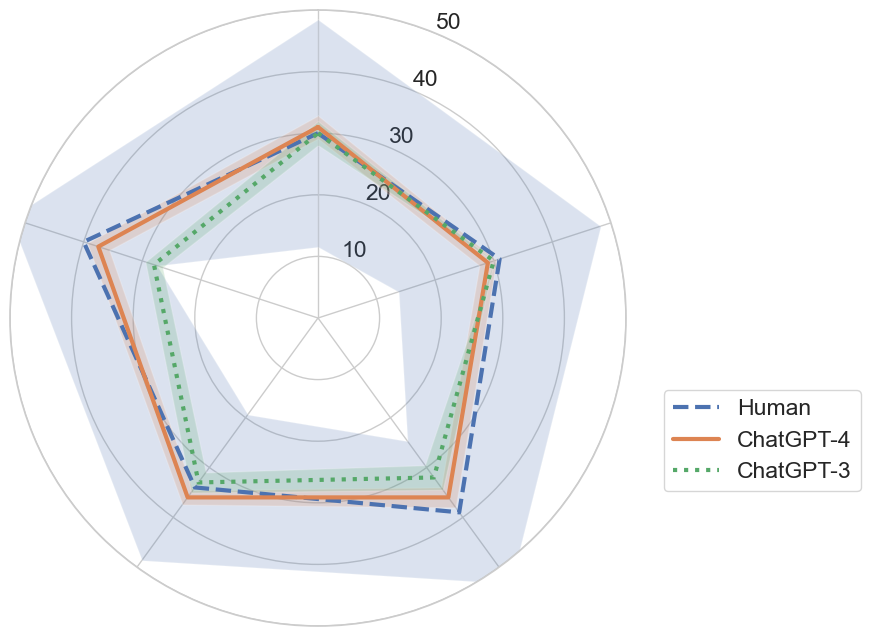

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

categories=['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
categories=[*dimensions]
print(categories)
categories = [''] * len(dimensions)
print(categories)
N = len(categories)
value_type = 'median'
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

hues = ['Human', 'ChatGPT-4', 'ChatGPT-3']
hue2line = {
    'Human': '--',
    'ChatGPT-4': '-',
    'ChatGPT-3': ':',
}
for hue in hues:
    d_scores = data[data['hue'] == hue][[*dimensions]].agg(['median', 'mean', 'std'])
    values = np.array(d_scores.loc[value_type])
    errors = np.array(d_scores.loc['std']) * 2
    print(values, errors)
    values = np.concatenate((values, [values[0]]))  # Close the plot
    errors = np.concatenate((errors, [errors[0]]))  # Close the plot
    print(values)

    ax.fill_between(angles, values - errors, values + errors, alpha=0.2)
    ax.plot(angles, values, linestyle=hue2line[hue], linewidth=3, label=hue)
 
plt.xticks(angles[:-1], categories)
# ax.set_rlabel_position(0)
plt.ylim(0,50)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.2))
# plt.savefig('figures/cmp-bigfive.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Prototyping

In [75]:
model_results_df = results_df[results_df['Model'] != 'Human']

dimension_selection = alt.selection_single(
    fields=['Dimension'], # Field to select on
    name='Select', # Dropdown selection name
    bind=alt.binding_select(options=sorted(results_df['Dimension'].unique())) # Create dropdown
)

# Generate the chart
chart = alt.Chart(model_results_df).mark_bar().encode(
    y=alt.Y('Model:N', axis=alt.Axis(title='')),
    x=alt.X('PercentileScore:Q', axis=alt.Axis(title='Percentile Score', format = '.2%')),
    color='Model:N',
    tooltip=['Model', 'PercentileScore', 'MedianScore']
).transform_filter(
    dimension_selection # Apply the filter transform
).properties(
    width=400,
    height=100
).add_selection(
    dimension_selection # Add the selection to the chart
)

chart

c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()``

alt.Chart(...)

In [43]:
results_df

,Model,PercentileScore,MedianScore,Dimension
0,ChatGPT-4,0.533521,31.0,Extraversion
1,ChatGPT-3,0.493509,30.0,Extraversion
2,Human,0.493509,30.0,Extraversion
3,ChatGPT-4,0.412749,29.0,Neuroticism
4,ChatGPT-3,0.454181,30.0,Neuroticism
5,Human,0.496704,31.0,Neuroticism
6,ChatGPT-4,0.323875,36.0,Agreeableness
7,ChatGPT-3,0.172372,32.0,Agreeableness
8,Human,0.482555,39.0,Agreeableness
9,ChatGPT-4,0.626959,36.0,Conscientiousness


In [44]:
lines = alt.Chart(results_df).mark_line().encode(
    y = alt.Y('MedianScore:Q', axis = alt.Axis(title = 'Median Score')).stack(None),
    x = alt.X('Dimension:N', axis = alt.Axis(labelAngle = 0, title = None)),
    color = alt.Color('Model:N'),
).properties(
    height = 300,
    width = 500,
)
lines

c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Concatenating the two charts

In [45]:
selection = alt.selection_single(fields = ['Dimension'], on = 'mouseover', nearest = True, empty = 'none')

# Create a chart with points
points = alt.Chart(results_df).mark_point().encode(
    y = alt.Y('MedianScore:Q', axis = alt.Axis(title = 'Median Score')),
    x = alt.X('Dimension:N', axis = alt.Axis(labelAngle = 0, title = None)),
    color = alt.Color('Model:N'),
    tooltip = ['Model', 'MedianScore', 'Dimension'],
    opacity = alt.condition(selection, alt.value(1), alt.value(0))
).add_params(
    selection
)

# Create a rule chart
rule = alt.Chart(results_df).mark_rule(color = 'lightgray', opacity = 0.7).encode(
    x = alt.X('Dimension:N', axis = alt.Axis(labelAngle = 0, title = None)),
).transform_filter(
    selection
)

chart1 = lines + rule + points

bar_chart = alt.Chart(model_results_df).mark_bar().encode(
    y=alt.Y('Model:N', axis=alt.Axis(title='')),
    x=alt.X('PercentileScore:Q', axis=alt.Axis(title='Percentile Score')),
    color='Model:N',
).transform_filter(
    selection # Apply the filter transform
).properties(
    width=400,
    height=50
)

text = alt.Chart(model_results_df).mark_text(align='left', fontSize = 12, color= 'black', dx=7).encode(
    y=alt.Y('Model:N'),
    x=alt.X('PercentileScore:Q', axis = alt.Axis(title='Percentile Score', format = '.2%')),
    text=alt.Text('PercentileScore:Q', format='.2%')
).transform_filter(
    selection
).properties(
    width=400,
    height=50

)

chart2 = bar_chart + text

plot = chart1 & chart2
plot.configure_view(strokeWidth=0).configure_axis(grid=False, domain=False)

c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\vegalite\v5\api.py:362: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col

alt.VConcatChart(...)

## Final Visualization

### Preparing data for percentile score chart

In [47]:
model_results_df

,Model,PercentileScore,MedianScore,Dimension
0,ChatGPT-4,0.533521,31.0,Extraversion
1,ChatGPT-3,0.493509,30.0,Extraversion
3,ChatGPT-4,0.412749,29.0,Neuroticism
4,ChatGPT-3,0.454181,30.0,Neuroticism
6,ChatGPT-4,0.323875,36.0,Agreeableness
7,ChatGPT-3,0.172372,32.0,Agreeableness
9,ChatGPT-4,0.626959,36.0,Conscientiousness
10,ChatGPT-3,0.471018,33.0,Conscientiousness
12,ChatGPT-4,0.379431,37.5,Openness
13,ChatGPT-3,0.049622,28.0,Openness


In [48]:
dimensions = model_results_df['Dimension'].unique()

# Define the models present in your dataset
models = ['ChatGPT-3', 'ChatGPT-4']

# Create the new rows for 0 and 100 percentile for both models and all dimensions
new_rows = []
for dimension in dimensions:
    for model in models:
        new_rows.append({'Model': model, 'PercentileScore': 0, 'MedianScore': None, 'Dimension': dimension})
        new_rows.append({'Model': model, 'PercentileScore': 1, 'MedianScore': None, 'Dimension': dimension})

# Convert the new rows into a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the original DataFrame
model_results_df_edge = pd.concat([model_results_df, new_rows_df])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11928\3869678149.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results_df_edge = pd.concat([model_results_df, new_rows_df])


In [49]:
model_results_df

,Model,PercentileScore,MedianScore,Dimension
0,ChatGPT-4,0.533521,31.0,Extraversion
1,ChatGPT-3,0.493509,30.0,Extraversion
3,ChatGPT-4,0.412749,29.0,Neuroticism
4,ChatGPT-3,0.454181,30.0,Neuroticism
6,ChatGPT-4,0.323875,36.0,Agreeableness
7,ChatGPT-3,0.172372,32.0,Agreeableness
9,ChatGPT-4,0.626959,36.0,Conscientiousness
10,ChatGPT-3,0.471018,33.0,Conscientiousness
12,ChatGPT-4,0.379431,37.5,Openness
13,ChatGPT-3,0.049622,28.0,Openness


### Percentile score chart

In [132]:
color_scheme = ['#1E88E5', '#FFC107']
scatter = alt.Chart(model_results_df).mark_circle(size = 80, opacity = 1).encode(
    y = alt.Y('Model:N', axis = alt.Axis(title = None, ticks = False, offset = 7) ),
    x = alt.X('PercentileScore:Q', axis = alt.Axis(title = "Percentile", format = '%', tickSize = 0, tickCount = 1, titleY = 20), scale = alt.Scale(domain = [0, 1])),
    color = alt.Color('Model:N', scale=alt.Scale(domain=['ChatGPT-4', 'ChatGPT-3'], range=color_scheme)),
).properties(
    width = 350,
    height = 100,
)

rule = alt.Chart(model_results_df).mark_rule(color = 'black', size = 1).encode(
    y = alt.Y('Model:N', axis = alt.Axis(title = None)),
)
text = alt.Chart(model_results_df).mark_text(align='center', fontSize = 12, color= 'black', dy=15).encode(
    y = alt.Y('Model:N', axis = alt.Axis(title = None, ticks = False)),
    x = alt.X('PercentileScore', axis = alt.Axis(title = "Percentile", format = '%', tickSize = 0, tickMinStep = 100), scale = alt.Scale(domain = [0, 1])),
    text = alt.Text('PercentileScore:Q', format='.2%')
)

edge = alt.Chart(new_rows_df).mark_point(size = 5, shape = 'wedge', color = 'black').encode(
    y = alt.Y('Model:N', axis = alt.Axis(title = None, ticks = False)),
    x = alt.X('PercentileScore:Q', axis = alt.Axis(title = 'Percentile', format = '%')),
)


rule + scatter + text + edge

c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\v

alt.LayerChart(...)

In [144]:
colors = ['#FFC107','#1E88E5', 'gray'] # Define the colors for the chart according to colorblind-friendly palette
base = alt.Chart(results_df).mark_bar().encode(
    x=alt.X('Model:N', axis=alt.Axis(title='', ticks = False, labelPadding=3, labelAngle=-45)),
    y=alt.Y('MedianScore:Q', axis=None),
    color = alt.Color('Model:N', scale=alt.Scale(domain=['ChatGPT-3', 'ChatGPT-4', 'Human'], range=colors)),
    column=alt.Column('Dimension:N', title = None),
    tooltip= [alt.Tooltip('Model:N', title='Respondent'), alt.Tooltip('MedianScore:Q', title='Median Score'), alt.Tooltip('Dimension:N', title='Personality Profile')]
)

base

c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [146]:
selection = alt.selection_point(fields = ['Dimension'], on = 'mouseover', clear = 'click', empty = False)
colors = ['#fd9830','#3d704d','#2eb4ea']

chart1 = base.add_params(selection).encode(
    opacity = alt.condition(selection, alt.value(1), alt.value(0.5))
).properties(
    width=75,
    height=300
)
chart2 = alt.layer(rule + scatter.transform_filter(selection) + text.transform_filter(selection) + edge)

chart = alt.vconcat(chart1, chart2, spacing=10, padding = 20, center = True).properties(
    title = {
        "text": ['Personality Traits of AIs'],
        "subtitle": ['“Big Five” personality profiles of ChatGPT-4 and ChatGPT-3 compared with the distributions of human subjects.']
    }   
).configure_title(fontSize=16, offset=20)
final_visualization = chart.configure_axis(grid=False, domain=False).configure_view(strokeWidth = 0).configure_legend(title = None)
final_visualization


c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\venv\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\envs\v

alt.VConcatChart(...)

### Hosting

In [148]:
import streamlit as st

st.altair_chart(final_visualization)

ImportError: DLL load failed while importing lib: The specified procedure could not be found.